10-1. 프로젝트: 한국어 데이터로 챗봇 만들기

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

Step 1 & 2 데이터 수집하기 & 데이터 전처리하기

In [ ]:
data = pd.read_csv('ChatbotData.csv')
data.head()

In [ ]:
len(data)

In [ ]:
# 중복인 열의 데이터를 확인하기
duplicate_indices = []

unique_Q = data['Q'].unique()

for unique in unique_Q:
    indices = data[data['Q'] == unique].index.tolist()
    if len(indices) > 1:
        print(f"중복된 헤드라인: {unique}")
        print(f"중복된 행의 인덱스: {indices}")
        duplicate_indices.extend(indices)
        print()

In [ ]:
duplicate_data = data.loc[duplicate_indices]
duplicate_data

In [ ]:
# 질문이 겹치는 경우, 항상 답변이 일치하지는 않는 것을 확인
# => 답변을 기준으로 drop (같은 질문도 다르게 답변할 수 있도록)
data.drop_duplicates(subset = ['A'], inplace=True)
print('전체 샘플수 :', (len(data)))

In [ ]:
print(data.isnull().sum())

한국어와 영어 전처리 과정의 차이(https://haru0229.tistory.com/57)

한국어는 영어와 달리 띄어쓰기로 구분하기 어렵다 (의존 형태소 떄문) => 띄어쓰기로 토큰화하는게 아니라 형태소 토큰화를 수행해야함 
+ 전처리하면서 생긴 문제 및 해결방안
1. 형태소 토큰화 수행
2. 의존 형태소를 불용어 처리 (Q(질문)에만 적용 , A(답변)은 자연스럽게 출력될 수 있도록 불용어 처리X) => 처음 프로젝트를 시작할 때에는 불용어 처리를 고려했지만, Q,A 모두 문장 길이가 짧아 불용어 처리를 하지 않아도 좋은 성능을 보여 최종 제출은 불용어 처리를 하지 않았다.
3. 정규화 사전은 찾지 못함 (정규화하지 않으면 vocab 크기가 커지는 문제 뿐만 아니라 의미 있는 단어가 자주 등장하지 않는 토큰으로 처리되어 삭제될 수 있음 => 지금은 정규화 없이 진행 후 추후에 다시 고민)
4. 영어가 나오면 우선 한글로 바꿈
5. 숫자의 경우 한글로 바꾸지는 않음
6. 3~5에서 발생하는 문제의 핵심은 결국 나중에 학습을 위해 드문 토큰들 삭제할 때, 지금 고민했던 토큰들이 삭제가 되는 것이 문제임, 우선 vocab크기가 너무 크지 않다면 따로 삭제하지 않는 것으로 진행 => 뒤에 전처리 요구사항에 SubwordTextEncoder를 사용하기 때문에 결국 어느정도 삭제될 수 밖에 없었음 (vocab size를 더 키우면 더 많이 보존할 수 있음; 회고에 추가 내용이 있습니다) 

In [ ]:
import re

def english_to_korean(word):
    """
    영어 단어를 한글 발음으로 변환
    예) SSD -> 에스에스디
    """
    mapping = {
        'a': '에이', 'b': '비', 'c': '씨', 'd': '디', 'e': '이',
        'f': '에프', 'g': '지', 'h': '에이치', 'i': '아이',
        'j': '제이', 'k': '케이', 'l': '엘', 'm': '엠',
        'n': '엔', 'o': '오', 'p': '피', 'q': '큐',
        'r': '알', 's': '에스', 't': '티', 'u': '유', 
        'v': '브이', 'w': '더블유', 'x': '엑스', 'y': '와이', 'z': '제트'
    }
    return "".join(mapping.get(ch.lower(), ch) for ch in word)

def preprocess_korean_sentence(sentence, remove_stopwords=True):
    """
    1. 앞뒤 공백 제거
    2. 영어 단어는 한글 발음으로 변환 (예: SSD -> 에스에스디)
    3. 최종적으로 한글 숫자 이외의 문자들을 제거
    """
    # 1. 앞뒤 공백 제거
    sentence = sentence.strip()
       
    # 2. 영어 변환: [A-Za-z]+ 패턴에 대해 영어 단어를 한글 발음으로 치환
    sentence = re.sub(r'[A-Za-z]+', lambda m: english_to_korean(m.group()), sentence)
    
    # 3. 한글, 숫자, 공백을 제외한 문자 제거
    sentence = re.sub(r'[^가-힣0-9\s]', '', sentence)
    
    
    return sentence

# 예시 사용
example_text = "SSD 제품은 12개의 기능이 있습니다. 가격은 1500원."
print(preprocess_korean_sentence(example_text, remove_stopwords=False))


In [ ]:
data.reset_index(inplace=True, drop=True)

preprocess_korean_sentence(data.loc[3,'Q'])
#영어가 한국어로 잘 변환되는 것을 확인, 현재 데이터셋에서 대부분 영어는 약어로 쓰이기 때문에
#이렇게 전처리하는게 적절하다고 판단

In [ ]:
for i in range(len(data)):
   data.loc[i,'question'] = preprocess_korean_sentence(data.loc[i,'Q'])
   data.loc[i,'answer'] = preprocess_korean_sentence(data.loc[i,'A'])

data.head()

Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [ ]:
questions = data['question']
answers = data['answer']

In [ ]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

In [ ]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

In [ ]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

In [ ]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

In [ ]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 질문과 답변의 토큰 길이 구하기
question_lengths = [len(tokenizer.encode(q)) for q in questions]
answer_lengths = [len(tokenizer.encode(a)) for a in answers]

# 전체 길이 리스트
all_lengths = question_lengths + answer_lengths

# 길이 분포 시각화
plt.figure(figsize=(8, 4))
plt.hist(all_lengths, bins=50, alpha=0.7, color='skyblue', label='Lengths')
plt.axvline(x=np.percentile(all_lengths, 97), color='b', linestyle='--', label='97 Percentile')
plt.axvline(x=np.percentile(all_lengths, 99), color='r', linestyle='--', label='99 Percentile')

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.legend()
plt.grid(True)
plt.show()

# 통계 분석
print(f"최대 길이: {np.max(all_lengths)}")
print(f"평균 길이: {np.mean(all_lengths):.2f}")
print(f"97% 백분위수: {np.percentile(all_lengths, 97)}")
print(f"99% 백분위수: {np.percentile(all_lengths, 99)}")

In [ ]:
# 샘플 99%를 활용하기 위해 최대 길이를 사용
MAX_LENGTH = 13

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 13으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

In [ ]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0 # 나누어 떨어지지 않으면 수행 불가

    self.depth = d_model // self.num_heads # 여기가 Q,K,V가 muti-head로 나뉘었을 때의 차원 수

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model) # 아직 어텐션 계산 전 형태

    self.dense = tf.keras.layers.Dense(units=d_model)# 다음 레이어로 넘어가는 최종 레이어 

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))# -1은 입력 문장의 길이
    return tf.transpose(inputs, perm=[0, 2, 1, 3])# (batch_size, num_heads, seq_len, depth)

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, tf.shape(query)[0])
    key = self.split_heads(key, tf.shape(key)[0])
    value = self.split_heads(value, tf.shape(value)[0])

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))# (batch_size, seq_len, d_model)

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis , : ]
print("슝=3")

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

In [ ]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

In [ ]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

In [ ]:
#지금 검증 세트를 따로 구성하지 않았고 생성모델이므로
#accuracy가 아닌 BLEU 점수를 기준으로 과적합을 방지
# BLEU점수 계산에 inference코드를 활용
def decoder_inference(sentence):
  sentence = preprocess_korean_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  return predicted_sentence
print("슝=3")

In [ ]:
import numpy as np
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu

# BLEU 점수를 기준으로 조기 종료하는 콜백 클래스
class BLEUEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, sample_questions, sample_answers, patience=5, threshold=0.9, check_interval=10):
        """
        sample_questions, sample_answers: 평가용으로 사용할 원본 질문과 정답 텍스트 (리스트)
        patience: BLEU 점수가 개선되지 않는 에포크 수
        threshold: BLEU 점수가 이 값 이상이면 조기 종료
        """
        super(BLEUEarlyStopping, self).__init__()
        self.sample_questions = sample_questions
        self.sample_answers = sample_answers
        self.patience = patience
        self.threshold = threshold
        self.check_interval = check_interval  # 10개 epoch마다 체크
        self.best_bleu = -1
        self.wait = 0
        self.last_bleu = -1  # 마지막 BLEU 점수 저장

    def on_epoch_end(self, epoch, logs=None):
        # 매 'check_interval'번째 epoch에 대해 BLEU 점수를 계산
        if (epoch + 1) % self.check_interval == 0:
            bleu_scores = []
            # 준비한 샘플 각각에 대해 예측을 수행하고 BLEU 점수를 계산합니다.
            for question, reference in zip(self.sample_questions, self.sample_answers):
                reference_decoded = tokenizer.decode([i for i in reference if i < tokenizer.vocab_size]) #답변
                question_decoded = tokenizer.decode([i for i in question if i < tokenizer.vocab_size]) #질문

                # sentence_generation 함수는 내부에서 decoder_inference를 호출하여 예측된 문장을 문자열로 리턴
                predicted = sentence_generation(question_decoded) #질문에 대한 모델의 답변
                
                # BLEU 점수를 계산하기 위해, 참조와 예측 문장을 단어 단위로 분리
                ref_tokens = reference_decoded.split()  # reference는 이제 확실히 문자열
                pred_tokens = predicted.split()  # predicted는 이미 문자열

                print("\n질문 : ", question_decoded)
                print("원래 답변 : ", ref_tokens)
                print("생성 답번 : ", pred_tokens)
                
                # nltk의 sentence_bleu 함수에 참조는 리스트의 리스트로 전달합니다.
                score = sentence_bleu([ref_tokens], pred_tokens, weights=(1, 1, 1, 1)) # 출력 문장의 길이가 짧아 1-gram 기준으로 계산 => 1~4gram 모두 평가하기로 다시 수정
                bleu_scores.append(score)

            
            avg_bleu = np.mean(bleu_scores)
            self.last_bleu = avg_bleu  # 마지막 BLEU 점수 저장
            print(f"Epoch {epoch}: Average BLEU = {avg_bleu:.4f}")
            
            # BLEU 점수가 개선되었는지 확인합니다.
            if avg_bleu > self.best_bleu:
                self.best_bleu = avg_bleu
                self.wait = 0
            else:
                self.wait += 1

            # patience 또는 threshold 조건을 만족하면 조기 종료합니다.
            if self.wait >= self.patience or avg_bleu >= self.threshold:
                print("Early stopping triggered based on BLEU score.")
                self.model.stop_training = True


    def get_last_bleu(self):
        """훈련 종료 후 마지막 BLEU 점수를 반환합니다."""
        return self.last_bleu


In [ ]:
len(questions)
# 7439개를 훈련에 사용하므로 BLEU 평가에 1%를 사용 (너무 오래 걸려서)

In [ ]:
EPOCHS = 200
# 평가용으로 사용할 원본 질문과 정답 텍스트
sample_questions = questions[:75]
sample_answers = answers[:75]

bleu_early_stopping = BLEUEarlyStopping(
    sample_questions=sample_questions,
    sample_answers=sample_answers,
    patience=5,
    threshold=0.9,
    check_interval= 10
)

# 훈련을 시작하고, 학습이 끝난 후 마지막 BLEU 점수를 출력합니다.
history = model.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=[bleu_early_stopping],  # CSVLogger와 BLEUEarlyStopping 콜백 추가
    verbose=1
)

# 훈련 종료 후 마지막 BLEU 점수 확인
last_bleu = bleu_early_stopping.get_last_bleu()
print(f"Final BLEU score: {last_bleu:.4f}")


Step 5. 모델 평가하기

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_korean_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

### 최종 결과

In [ ]:
sentence_generation('오늘 날씨 어때?')

In [ ]:
sentence_generation('배가 너무 아파')

### ver0에서 아무런 제약 없이 100epoch를 돌렸을 때의 결과 입니다.

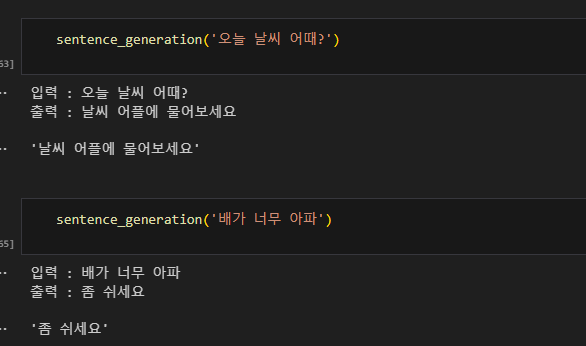



### BLEU 점수에 1-gram만을 기준으로 30epoch를 돌렸을 때의 결과입니다.

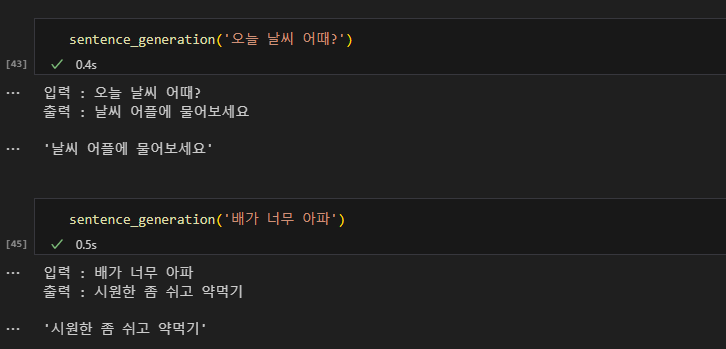

### 회고
0. ver0에서는 accuracy가 0.1583으로 학습이 마무리 되었는데 최종 결과를 확인하면 성능이 너무 좋게 나와서 sparse categorical accuracy가 어떻게 측정되는지 알아보았다.
    - y_pred는 model의 최종 출력으로 (batch_size, seq_len, vocab_size)이다.
    - sparse categorical loss에 y_true와 y_pred가 매개변수로 들어가고 from_logits=True이면, y_pred는 argmax가 적용된다고 한다.
    - 그렇다면 accuracy는 예측 토큰 끼리의 정확도를 의미한다.
    - 결론적으로 생성 모델에서 accuracy보다 정성평가가 더 중요하다는걸 정말 많이 느끼게 되었다.
    - **다른 동료 분들과 코드를 공유하면서 확인해보니 학습에 사용할 문장의 최대 길이가 데이터셋이 나오는 문장들보다 너무 길어서 accuracy에 문제가 생겼던 걸 확인할 수 있었고 이를 추후에 수정할 계획이다**

1. 최종에서는 문장 최대 길이를 수정하여 이전보다 납득할 수 있는 accuracy 0.4768에서 학습을 마무리하였다. 이전 시도에서 accuracy기반으로 평가할 수 없다는 것을 정리할 수 있어서, BLEU 점수를 도입하였고 문장 길이가 짧아 1-gram 기준으로만 평가하여 0.9이상이 나오면 학습을 종료하도록 설정하였다. 10번의 epoch마다 BLEU점수를 측정하였으며 30번째 epoch에서 0.9733 점수를 기록하게 되어 학습을 멈추게 되었다.
    - accuracy가 0.4768인데에 반해, BLEU는 0.9733인 것으로 보아 padding으로 인해 정확한 accuracy 측정이 어려운 것으로 예상하고 추후에 더 자세히 찾아보고 정리해보아야겠다.
    - BLEU가 0.9733이라면 대부분의 답변이 dataset에 있는 답변 그대로를 출력하는 모습일 것으로 예상이 된다. 적절한 Threshold 설정이 정말 중요하겠다는 것을 확실히 체감할 수 있었다.
    - 신기한 점은 ver0에서는 "배가 너무 아파" 라는 질문에  "좀 쉬세요" 라는 그럴듯한 답변을 얻을 수 있었는데 최종 버전에서는 "시원한 좀 쉬고 약먹기" 라는 이상한 답변을 얻을 수 있었다.
    - 이 결과는 1-gram만을 기준으로 평가했기 때문이란 것을 알 수 있었다. 문장 길이가 짧아 학습하는 과정에서 2-gram이상 겹치는 항목이 없어 별도의 조치가 필요하다는 로그가 출력이 되어 1-gram만을 기준으로 해도 괜찮을거라 생각했지만 확실히 1-gram만 평가했을 때에는 단어 간의 관계나 문맥이 반영되지 않기 때문에 이런 문제가 발생했다고 생각하고 1~4gram 모두 평가될 수 있도록 설정하여 다시 학습시켰다.
    - 

2. 전체적인 프로젝트 요구사항보다 먼저 한국어 텍스트 전처리에 대해 고민할 때, vocab 크기가 커지더라도 빈도 수를 고려해서 토큰을 줄이지 말아야겠다는 결론을 내렸었다. 왜냐하면 드물게 등장하는 토큰 중 해당 문장에서 중요한 의미를 가지는 경우가 많다고 판단했기 때문이다. 하지만 프로젝트의 요구사항에 따라 전처리를 따라가다 보니 어떤 토큰을 명시적으로 삭제하지 않고 vocab 크기를 먼저 결정짓는 방식의 토큰화를 진행하게 되었다. 해당 토큰화 방식이 어떻게 이루어지는지 더 자세히 살펴보았다.
    - 서브워드 토큰화 원리
    - 예. birdstrike => bird와 strike의 서브워드로 분리
    - 주어진 말뭉치(corpus; 훈련데이터셋)에서 가장 자주 등장하는 서브워드 단위를 찾아 vocab를 구축한다.
    - Greedy 토큰화; 문장을 토큰화할 때, 가장 긴 매칭 서브워드부터 시작하여 점진적으로 작은 단위로 분할한다.
    - UNKOWN 처리; 어휘에 없는 단어는 더 작은 서브워드 단위로 분해된다. 개별 문자 단위까지도 분해할 수 있다.
    - 형태학적으로 복잡한 언어나 신조어가 많은 도메인에 유용하다
    - 결국 vocab을 구성하게 되는 방식은 항상 토큰의 등장 빈도수에 따라 결정되는 것 처럼 느껴진다. 과연 항상 그럴까?

3. 이 내용은 Transformer 구조를 세세하게 뜯어 볼때 생겼던 의문 사항과 결론으로 다음에 헷갈리지 않기 위해 기록해놓으려 한다.
    - tensor나 matrix 등 축이 3개 이상으로 많아질 때, Transpose를 적용하면 맨 마지막 2 축에만 적용된다.
    - LSTM이나 RNN에서 유사한 태스크에 대해 학습할 때, 생각해보면 padding mask 라는걸 사용하지 않는 것을 알 수 있다. 왜냐하면 입력 sequence에서 패딩은 0으로 입력하기 때문에 복잡한 네트워크를 지나더라도 0이 출력되어 계산에 반영이 안되기 때문이다. 하지만 Transformer에서는 padding mask를 사용하는데 그 이유는 똑같이 0으로 출력되지만 attention_weight(어텐션 점수)를 계산할 때에는 Softmax 함수를 사용하기 때문에, 'e^0'은 '1'이 되어 패딩이 계산에 관여하게 되는 문제가 생긴다. 따라서 어떤 위치에 패딩이 들어갔는지 기억하고 해당 위치에 매우 큰 음수를 곱해서 0에 가깝게 만들어 줘야 한다. 이러한 이유로 padding mask가 필요하다.
    - [포지셔널 인코딩](https://medium.com/thedeephub/positional-encoding-explained-a-deep-dive-into-transformer-pe-65cfe8cfe10b)에서 뒤로 갈수록 값의 변화가 없고 앞쪽으로 올수록 값의 변화가 잦은 이유는 pos/var 가 주기 함수의 변수로 들어가는데 뒤로 갈수록 var의 크기가 커져 주기가 늘어나는 효과가 나타나기 때문이다. 그럼 왜 이렇게 구현했을까? 논문의 저자는 "모델이 상대적 위치에 따라 주의를 기울이는 법을 쉽게 학습할 수 있을 것"이라는 가설을 세웠으며 이에 따라 고정된 오프셋k에 대해 PE(pos+k)는 PE(pos)의 선형 함수로 표현될 수 있다라고 하였다. 이 말은 PE(pos)가 PE(pos+K)로 이동할 수 있게 만드는 행렬 M이 존재하고 이 행렬 M은 pos와 독립적이라는 의미라고 한다. 즉, 시작하는 절대 위치와 관계없이(pos가 변화하여도) 같은 방식으로(M*PE(pos)로) 작동한다는 뜻이다. 따라서 절대적인 위치 정보를 사용하지 않고도 상대적인 위치 정보를 학습할 수 있도록 한다는 의미이다. 예. 'not'이 문장에서 어디에 나타나는지에 관계 없이 근처 단어의 의미를 수정한다는 것을 학습할 수 있다는 의미.

        - cf.[불용어 사전](https://gist.github.com/spikeekips/40eea22ef4a89f629abd87eed535ac6a) : 불용어 사전을 가져온 github 주소입니다.